# Starting from scratch, build up everything

- Features, testing framework, etc.

Learnings
- objective function
- ensemble across different folds for less variance

- val set improvement == leaderboard improvement (but need to retrain for each)

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor, DMatrix
import shap
import lightgbm as lgb
import time
import functools
shap.initjs()
from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt

/home/hice1/apatel929/.conda/envs/testenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIRECTORY = './data/'
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date']).sort_values(by='date')
test = pd.read_csv(DIRECTORY + 'sales_test.csv', parse_dates=['date']).sort_values(by='date')
inventory = pd.read_csv(DIRECTORY + 'inventory.csv')
weight = pd.read_csv(DIRECTORY + 'test_weights.csv')

In [3]:
train = train.dropna(axis=0).sort_values(by='date').reset_index(drop=True)
test = test.sort_values(by='date').reset_index(drop=True)

In [4]:
train.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,2346,2020-08-01,Prague_1,4086.0,55.12,25.29,0.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5296,2020-08-01,Prague_3,2466.0,105.36,2.62,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1175,2020-08-01,Prague_3,2466.0,111.14,81.95,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,399,2020-08-01,Prague_3,2466.0,38.41,12.24,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3916,2020-08-01,Prague_2,2424.0,53.52,56.81,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Add some naive features
from statsmodels.tsa.deterministic import CalendarFourier

def date(df):
    df = df.reset_index(drop=True)
    df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
    df['day_of_week'] = df['date'].dt.day_of_week
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    cal_fourier = CalendarFourier("YE", 4)
    cal_fourier = cal_fourier.in_sample(df['date']).reset_index(drop=True)
    assert(len(cal_fourier) == len(df))
    df = pd.concat([df, cal_fourier], axis=1)
    return df

def rolling_sales(df):
    for lag in [14,21]:
        df[f'lag{lag}'] = df['sales'].shift(lag)
    for rolling in [2, 7, 30, 90, 365]:
        df[f'rolling{rolling}_lag14'] = df['lag14'].rolling(rolling, min_periods=rolling//2).mean()
    return df

def zscores(df):
    # price, total orders, discounts
    discount_cols = [col for col in df.columns if '_discount' in col]
    df['discount'] = df[discount_cols].max(axis=1)

    cols = ['sell_price_main', 'total_orders', 'discount']
    for col in cols:
        df[f'{col}_zs'] = (df[col] - df.groupby('unique_id')[col].transform('mean')) / df.groupby('unique_id')[col].transform('std').replace(0, 1)
        df[f'{col}_detrended'] = df[f'{col}_zs'] - df.groupby(['date', 'warehouse'])[f'{col}_zs'].transform('mean')
    return df
    

In [6]:
all_data = pd.concat([train, test], axis=0)
all_data = date(all_data)
all_data = rolling_sales(all_data)
all_data = zscores(all_data)

## Xgboost

In [29]:
cat_cols = list(all_data.select_dtypes('object').columns) + list(['unique_id'])
all_data[cat_cols] = all_data[cat_cols].astype('category')

In [30]:
train_start = pd.to_datetime('2022-01-01')
train_end = pd.to_datetime('2024-06-02')

train_split = all_data[(all_data['date'] >= train_start) & (all_data['date'] <= train_end)]
test_split = all_data[all_data['date'] > train_end]

In [31]:
xgb_params = {
    'n_estimators': 10000,
    'objective': 'reg:squarederror',
    'enable_categorical': True,
    'learning_rate': 0.1,
    'device': 'cuda',
    'min_child_weight': 1,
    'early_stopping_rounds': 20,
    'lambda': 0.8,
    'seed': 42
}

In [32]:
# Just do val set
drop_cols = ['date', 'sales']
kf = RepeatedKFold(n_splits=3, n_repeats=1)

test_preds = []
oof_pred_df = pd.DataFrame(index=train_split.index, columns=['predictions', 'actual'])
model = None

for i, (train_idx, test_idx) in enumerate(kf.split(train_split)):
    X_train, X_test = train_split.iloc[train_idx].drop(columns=drop_cols), train_split.iloc[test_idx].drop(columns=drop_cols)
    y_train, y_test = np.sqrt(train_split.iloc[train_idx]['sales']), np.sqrt(train_split.iloc[test_idx]['sales'])
    
    final_X_test = test_split.drop(columns=drop_cols)

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=1000
    )

    fold_test_pred = xgb_model.predict(final_X_test)**2
    test_preds.append(fold_test_pred)

    oof_pred_df.iloc[test_idx,0] = xgb_model.predict(X_test)**2
    oof_pred_df.iloc[test_idx,1] = y_test**2

[0]	validation_0-rmse:6.03569
[1000]	validation_0-rmse:1.29963
[2000]	validation_0-rmse:1.24378
[2821]	validation_0-rmse:1.22869
[0]	validation_0-rmse:6.01942
[1000]	validation_0-rmse:1.30418
[2000]	validation_0-rmse:1.24905
[3000]	validation_0-rmse:1.23379
[3108]	validation_0-rmse:1.23303
[0]	validation_0-rmse:6.04101
[1000]	validation_0-rmse:1.30327
[2000]	validation_0-rmse:1.24869
[2917]	validation_0-rmse:1.23325


In [33]:
# Check oof prediction score
train_split_weights = train_split['unique_id'].map(weight.set_index('unique_id')['weight']).reset_index(drop=True)
train_split_weights.name = 'weight'
actually_predicted = pd.concat([oof_pred_df.reset_index(drop=True), train_split_weights], axis=1).dropna(axis=0)

mean_absolute_error(actually_predicted['predictions'], actually_predicted['actual'], sample_weight=actually_predicted['weight'])

13.344727689749792

In [34]:
np.mean(test_preds, axis=0)

array([25.678751, 27.59867 , 80.5032  , ..., 13.395349, 71.44407 ,
       26.419733], dtype=float32)

In [35]:
res_df = pd.DataFrame({
    'id': test_split['unique_id'].astype(str) + '_' + test_split['date'].astype(str),
    'sales_hat': np.mean(test_preds, axis=0)
    })
res_df.to_csv('submission.csv', index=False)

In [49]:
for fold in range(3):
    fold_prediction = res_df.copy()
    fold_prediction['sales_hat'] = test_preds[fold]
    fold_prediction.to_csv(f'own_submission_fold{fold}.csv', index=False)

/home/hice1/apatel929/.conda/envs/testenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


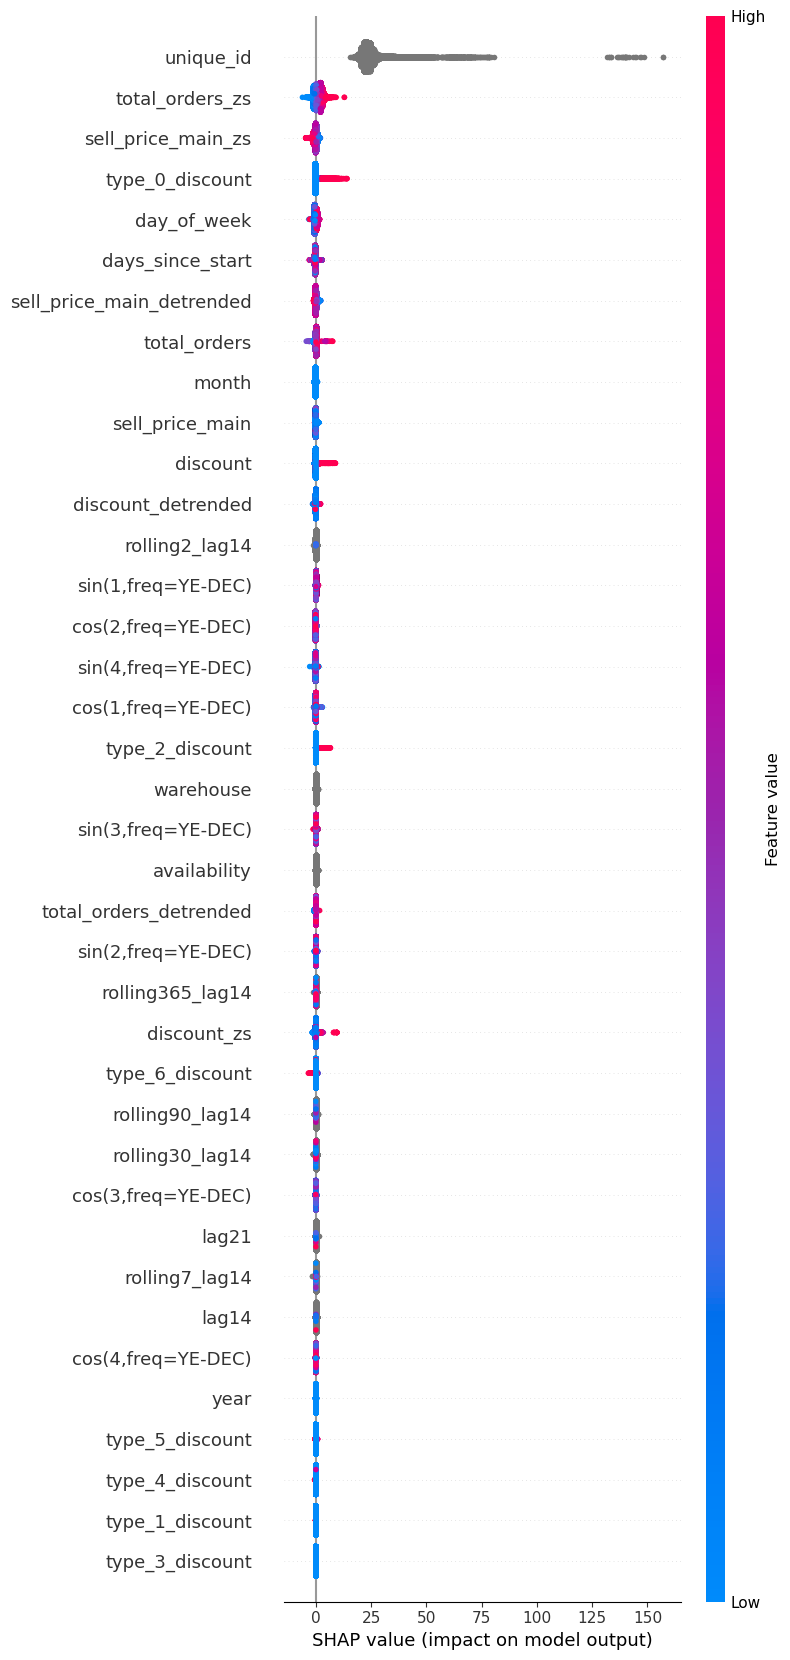

In [36]:
test_dm = DMatrix(test_split.drop(columns=drop_cols), enable_categorical=True)
shap_values = xgb_model.get_booster().predict(test_dm, pred_contribs=True)
shap.summary_plot(shap_values[:,:-1], test_split.drop(columns=drop_cols), max_display=40)